## Preparing Environments

In [64]:

import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [65]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)
print(torch.__version__)

cuda
1.12.1


## Loading Models

In [66]:
clip.available_models()

model, preprocess = clip.load("ViT-B/32", device=device)

In [67]:
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


## Preparing Classes and Prompts


- method 1. template를 사용하지 않은 단일어로 구성된 Prompt
- method 2. 간단한 template를 사용
- method 3. 객체 상호작용에 대한 정보가 들어간 template 사용
- method 4. 평서문 형식의 template를 사용

In [134]:
classes = ['walking', 
           'throwing trash', 
           'standing', 
           'putting trash',
           'dumping trash',
           'running',
           'sitting'
           ]

In [135]:

templates0 = ['{}']

templates1 = ['a photo of {}.']


templates2 = ['a photo of action {}.', 'a picture of action {}.',
            'Human action of {}.', '{}, an action.', '{} this is an action.',
            '{}, a image of action.', 'Playing action of {}.', '{}.',
            'Playing a kind of action, {}.', 'Doing a kind of action, {}.',
            'Image classification of {}.', 'A image of {}.', 'The man who is {}.',
            'The woman who is {}.']

templates3 = ['a photo of action {} ', 'a picture of action {} .',
            'Human action of {}.', '{} , an action.', '{} this is an action.',
            '{}, a image of action.', 'Playing action of {}.', '{}.',
            'Playing a kind of action, {}.', 'Doing a kind of action, {}.',
            'Image classification of {}.', 'A image of {}.',]

templates4 = ['Look, the human is {}.', 'Can you recognize the action of {}?', 
              'The man is {}.','The woman is {}.']
#prompt engineering에 해당하는 부분

## Loading the Images

In [148]:
import os

filelist = os.listdir('actions')

print("files : ", len(filelist))


files :  328


## Creating Zero-shot classifier weights

In [149]:
import tqdm

def zeroshot_classifier(classnames, templates = None):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in classnames:
            texts = [template.format(classname) for template in templates]
            print(texts[0])
            texts = clip.tokenize(texts).cuda() #tokenize
            class_embeddings = model.encode_text(texts) #embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            class_embedding
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
    return zeroshot_weights


zeroshot_weights = zeroshot_classifier(classes, templates4)

Look, the human is walking.
Look, the human is throwing trash.
Look, the human is standing.
Look, the human is putting trash.
Look, the human is dumping trash.
Look, the human is running.
Look, the human is sitting.


In [150]:
def accuracy(output, target, topk=(1,)):
    pred = output.topk(max(topk), 1, True, True)[1].t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]


def clean(src, dest):
    for dir in os.listdir(src):
        for file in os.listdir(f'{src}/{dir}'):
            os.rename(f'{src}/{dir}/{file}', f'{dest}/{file}')
    

In [151]:
with torch.no_grad():
    for file in sorted(filelist, key=lambda x: int(x.split('.')[0])):
        img = preprocess(Image.open(f'actions/{file}')).unsqueeze(0).to(device)
        print(type(img), img.size())
        image_features = model.encode_image(img)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        logits = 100. * image_features @ zeroshot_weights
        probs = logits.softmax(dim=-1).cpu().numpy()
        print(probs, classes[probs.argmax()], file)
        if classes[probs.argmax()] not in os.listdir('results'):
            os.makedirs(f'results/{classes[probs.argmax()]}')
        os.rename(f'actions/{file}', f'results/{classes[probs.argmax()]}/{file}')
        


<class 'torch.Tensor'> torch.Size([1, 3, 224, 224])
[[0.619    0.1471   0.09955  0.04083  0.03604  0.05164  0.005615]] walking 12.jpg
<class 'torch.Tensor'> torch.Size([1, 3, 224, 224])
[[0.0689   0.2769   0.06573  0.2156   0.3555   0.01198  0.005314]] dumping trash 13.jpg
<class 'torch.Tensor'> torch.Size([1, 3, 224, 224])
[[0.01962  0.2211   0.04422  0.337    0.3645   0.00431  0.009415]] dumping trash 14.jpg
<class 'torch.Tensor'> torch.Size([1, 3, 224, 224])
[[2.626e-03 1.785e-01 4.398e-03 3.284e-01 4.851e-01 5.860e-04 4.356e-04]] dumping trash 15.jpg
<class 'torch.Tensor'> torch.Size([1, 3, 224, 224])
[[0.014656 0.212    0.014206 0.3442   0.4087   0.003649 0.002468]] dumping trash 16.jpg
<class 'torch.Tensor'> torch.Size([1, 3, 224, 224])
[[0.3037   0.3184   0.05035  0.1786   0.09863  0.04587  0.004612]] throwing trash 17.jpg
<class 'torch.Tensor'> torch.Size([1, 3, 224, 224])
[[0.1897  0.524   0.05185 0.1432  0.06256 0.02301 0.00591]] throwing trash 18.jpg
<class 'torch.Tensor'> t

In [147]:
clean('results', 'actions')

In [214]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F

title_font = {
    'fontsize': 16,
    'fontweight': 'bold'
}

def show(imgs, size, title):
    if not isinstance(imgs, list): # 하나의 이미지일때
        imgs = [imgs]
    if size < 16:
        plt.rcParams["figure.figsize"] = [3,3]
    else:
        plt.rcParams["figure.figsize"] = [20,20]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False) # 총 사진의 개수만큼 plot
    for i, img in enumerate(imgs):
        img = img.detach() # 학습 그래프에서 제외
        img = F.to_pil_image(img) # torch.tensor 에서 pil 이미지로 변환
        plt.title(f'{title}', pad=20, fontdict=title_font, color = 'white')
        axs[0, i].imshow(np.asarray(img)) # numpy 배열로 변경후, 가로로 이미지를 나열
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

torch.Size([3, 776, 4130])
torch.Size([3, 518, 4130])
torch.Size([3, 256, 256])
torch.Size([3, 260, 518])
torch.Size([3, 2324, 4130])
torch.Size([3, 2324, 4130])


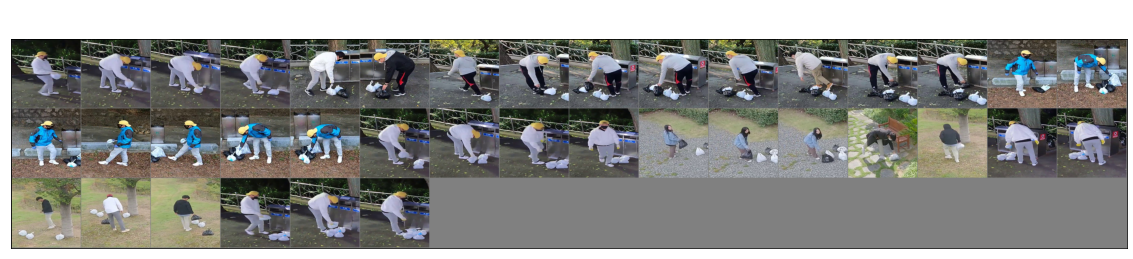

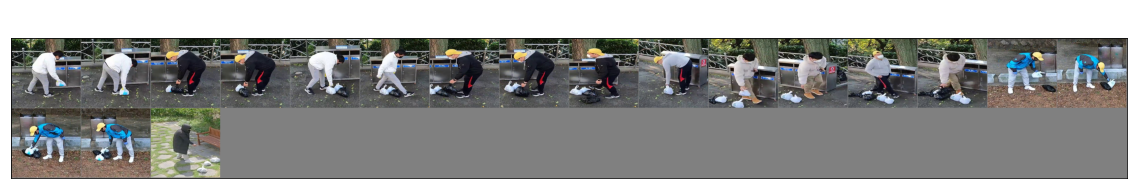

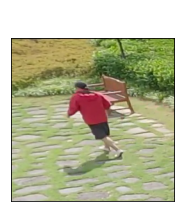

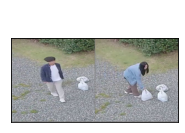

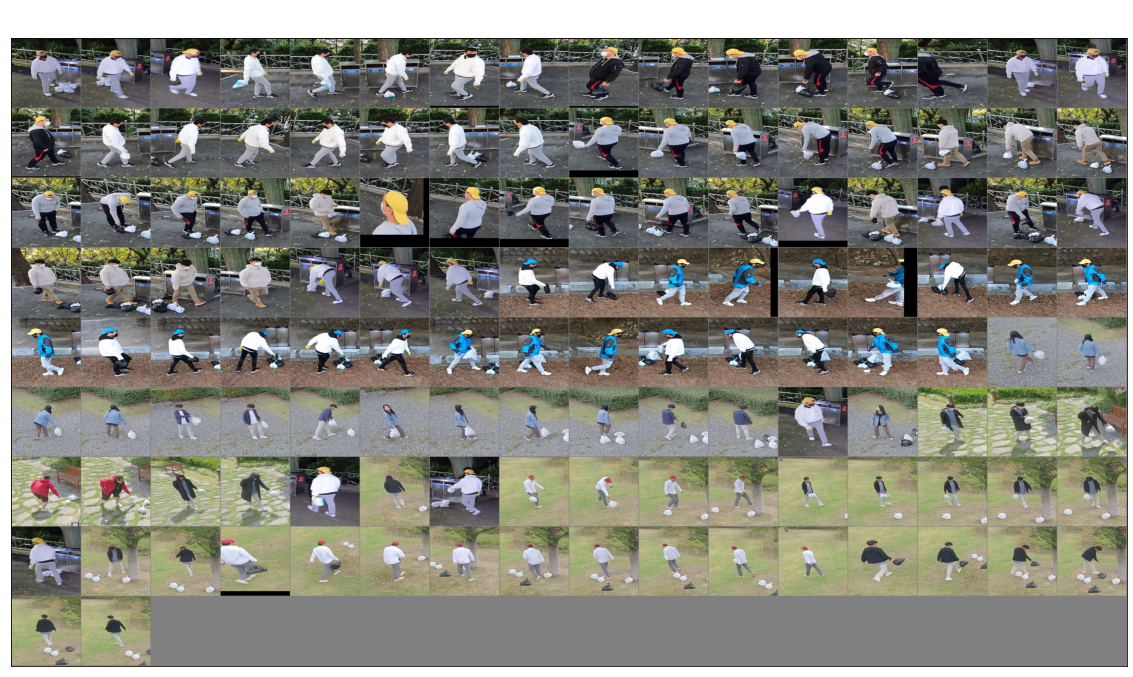

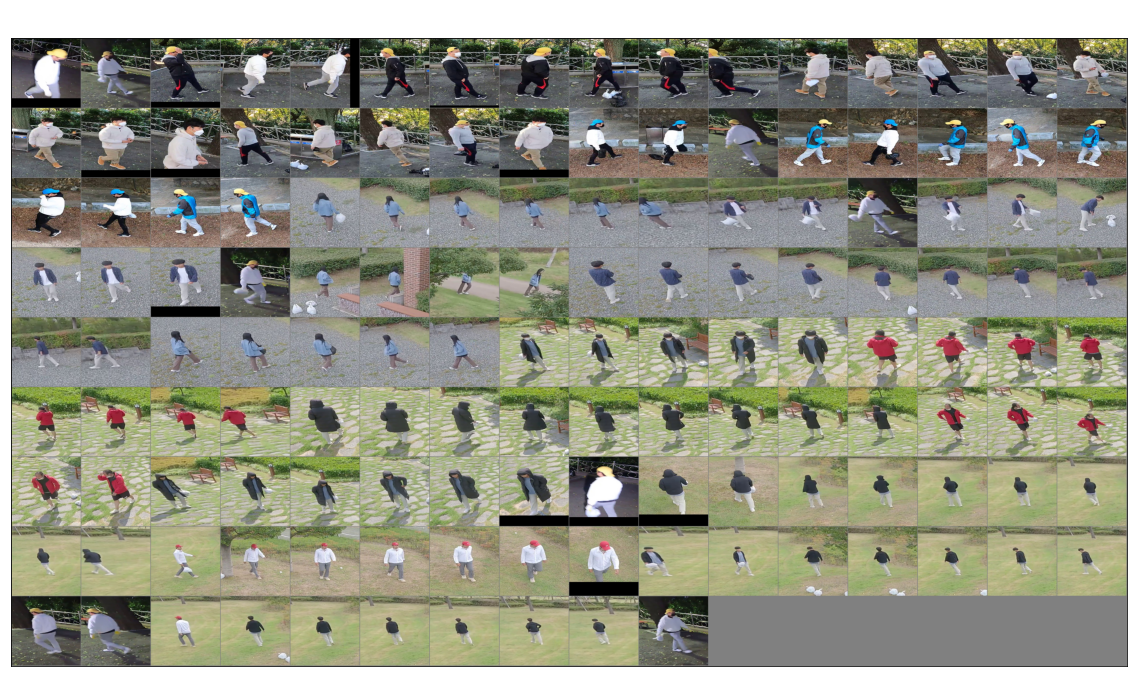

In [215]:
# code from https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path

# read_image : 이미지 파일을 읽어옵니다.



for dir in os.listdir('results'):
    img_list = []
    for image in os.listdir(f'results/{dir}'):
        new_img = read_image(str(Path('results') / f'{dir}/{image}'))
        new_img = F.resize(new_img, (256,256))
        img_list.append(new_img)
    grid = make_grid(img_list, nrow=16, pad_value=128)
    show(grid, len(img_list), dir)


# dog1_int = read_image(str(Path('assets') / 'dog1.jpg')) # assets/dog1.jpg
# dog2_int = read_image(str(Path('assets') / 'dog2.jpg')) # assets/dog2.jpg

# 두 이미지를 리스트로 연결해 줍니다.
# dog_list = [dog1_int, dog2_int] # size:(2,3,500,500)

# grid = make_grid(dog_list) # Default : padding(2)

# # grid shape (Channel, Height, Width)
# # Channel : 3 (RGB)
# # Height : 504 
# # Width : 1006 
# print(grid.shape) # torch.Size([3, 504, 1006])

# show(grid)